### Случайный лес на данных для прогнозирования оттока

Загрузка данных после балансировки по SMOTE из заранее сохраненных файлов

In [1]:
import pandas as pd
os_data_X = pd.read_csv('os_data_X.csv')
os_data_y = pd.read_csv('os_data_y.csv')
os_data_y = os_data_y.values.ravel()

In [2]:
os_data_X

,age,dependents,year_income,month_client,total_products,m_inactive_12,contacts_12,credit_limit,total_amt_chng_Q4Q1,total_transactions,...,"edu_level_high, not graduated",marital_status_civil partnership,marital_status_divorced,marital_status_married,marital_status_single,marital_status_widow,card_category_Blue,card_category_Gold,card_category_Platinum,card_category_Silver
0,57,2,272751.339000,52,6,2,4,109740,0.591000,1327,...,0,0,0,1,0,0,1,0,0,0
1,48,2,91851.467290,36,4,3,2,95050,0.727000,3616,...,0,0,1,0,0,0,1,0,0,0
2,32,2,166396.869500,20,6,3,4,22350,0.912000,2905,...,0,0,0,1,0,0,1,0,0,0
3,54,2,151750.094900,48,6,1,4,66100,0.894000,3328,...,0,0,1,0,0,0,1,0,0,0
4,50,1,167622.292800,36,6,3,2,53490,0.671000,2122,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5839,51,3,114306.160359,43,1,2,3,345160,0.684159,6652,...,0,0,0,0,0,0,1,0,0,0
5840,45,3,144869.450100,40,1,3,3,31832,0.631548,2117,...,0,0,0,0,0,0,1,0,0,0
5841,46,4,223210.973777,38,3,2,3,36736,0.738341,2239,...,0,0,0,1,0,0,1,0,0,0
5842,53,2,144869.450100,36,5,3,1,35874,0.663658,2310,...,0,0,0,0,0,0,1,0,0,0


In [3]:
os_data_y

array([0, 0, 0, ..., 1, 1, 1])

Это задача классификации, поэтому будем использовать метрику accuracy для оценки качества модели. Для начала построим самый простой классификатор, который будет нашим baseline. Важно, что мы будем при разбивки набора данных для кросс-валидации использовать информацию о стратах, т.е. делать стратифицированную разбивку

In [4]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Инициализируем стратифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

# Инициализируем наш классификатор с дефолтными параметрами
rfc = RandomForestClassifier(random_state=3, n_jobs=-1, oob_score=True)

# Обучаем на тренировочном датасете
results = cross_val_score(rfc, os_data_X, os_data_y, cv=skf)

# Оцениваем долю верных ответов на тестовом датасете
print("Доля правильных ответов на кросс-валидации: {:.2f}%".format(results.mean()*100))

Доля правильных ответов на кросс-валидации: 95.89%


Оценим, как ведут себя кривые валидации при изменении основных параметров случайного леса.

1. Количество деревьев `n_estimators` - начиная с 20 деревьев и до 100 деревьев

In [5]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [20, 30, 50, 75, 100]

# Обучаем на обучающей
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=3, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []

    for train_index, test_index in skf.split(os_data_X, os_data_y):
        X_train, X_test = os_data_X.iloc[train_index], os_data_X.iloc[test_index]
        y_train, y_test = os_data_y[train_index], os_data_y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

In [6]:
import numpy as np
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Наилучшая доля правильных ответов на кросс-валидации {:.2f}% достигается для {} деревьев".format(max(test_acc.mean(axis=1))*100,
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Наилучшая доля правильных ответов на кросс-валидации 95.89% достигается для 100 деревьев


График

Text(0.5, 0, 'Число деревьев')

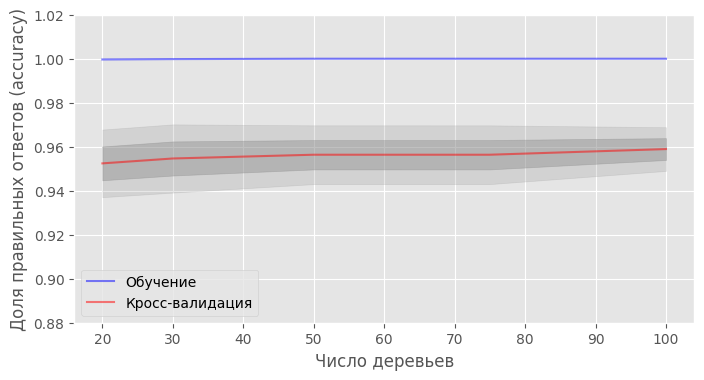

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='Обучение')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='Кросс-валидация')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Доля правильных ответов (accuracy)")
ax.set_xlabel("Число деревьев")

Как видно, при достижении определенного числа деревьев наша доля верных ответов на тесте выходит на асимптоту, и вы можете сами решить, сколько деревьев оптимально для вашей задачи

На рисунке также видно, что на обучающей выборке мы смогли достичь 100% точности, это говорит нам о переобучении нашей модели. Чтобы избежать переобучения, мы должны добавить **параметры регуляризации** в модель:

- это входные параметры `max_depth` (число уровней - максимальная глубина дерева) и
- `min_samples_leaf` (минимальное число объектов в одном листе дерева)

2. Начнем с параметра максимальной глубины – `max_depth`. (зафиксируем при этом к-во деревьев `n_estimators` = 75)

In [8]:
# Создаем списки для сохранения accuracy на обучающей и тестовой выборке
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=75, random_state=3, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(os_data_X, os_data_y):
        X_train, X_test = os_data_X.iloc[train_index], os_data_X.iloc[test_index]
        y_train, y_test = os_data_y[train_index], os_data_y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Наилучшая доля правильных ответов на кросс-валидации {:.2f}% достигается при глубине {} уровней".format(max(test_acc.mean(axis=1))*100,
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Наилучшая доля правильных ответов на кросс-валидации 95.72% достигается при глубине 22 уровней


График

Text(0.5, 0, 'Максимальная глубина дерева')

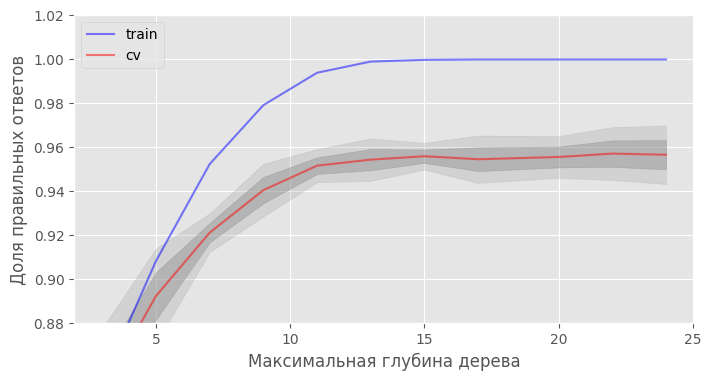

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Доля правильных ответов")
ax.set_xlabel("Максимальная глубина дерева")

Параметр `max_depth` хорошо справляется с регуляризацией модели, и мы уже не так сильно переобучаемся.

2. Параметр `min_samples_leaf`

In [10]:
# Создаем списки для сохранения accuracy на обучающей и тестовой выборках
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=75, random_state=3, n_jobs=-1,
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(os_data_X, os_data_y):
        X_train, X_test = os_data_X.iloc[train_index], os_data_X.iloc[test_index]
        y_train, y_test = os_data_y[train_index], os_data_y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Наилучшая доля правильных ответов на кросс-валидации {:.2f}% достигается при минимальном числе объектов в листе: {} ".format(max(test_acc.mean(axis=1))*100,
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Наилучшая доля правильных ответов на кросс-валидации 95.64% достигается при минимальном числе объектов в листе: 1 


График

Text(0.5, 0, 'Минимальное число объектов в листе')

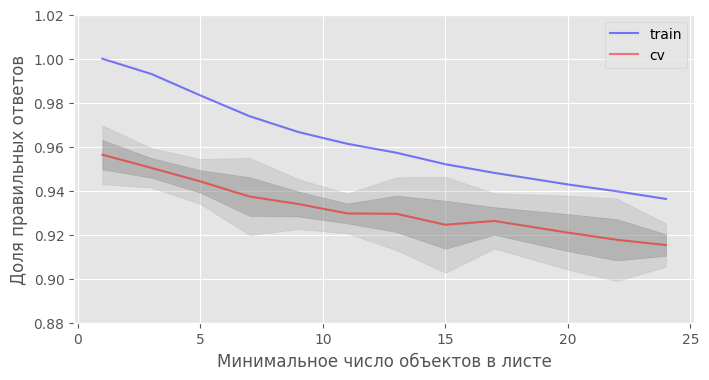

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Доля правильных ответов")
ax.set_xlabel("Минимальное число объектов в листе")

Естественно, при увеличении минимального числа объектов в листе доля правильных ответов будет падать (наша метрика), но зато мы значительно снижаем уровень переобучения

3. Параметр `max_features` (число признаков из признакового пространства, которое учитывается для лучшего разбиения)

In [12]:
# Создаем списки для сохранения accuracy на обучающей и тестовой выборке
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Обучаем
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=75, random_state=3, n_jobs=-1,
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(os_data_X, os_data_y):
        X_train, X_test = os_data_X.iloc[train_index], os_data_X.iloc[test_index]
        y_train, y_test = os_data_y[train_index], os_data_y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Наилучшая доля правильных ответов на кросс-валидации {:.2f}% достигается при числе признаков: {}".format(max(test_acc.mean(axis=1))*100,
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

Наилучшая доля правильных ответов на кросс-валидации 95.82% достигается при числе признаков: 4


График

Text(0.5, 0, 'Максимальное число признаков')

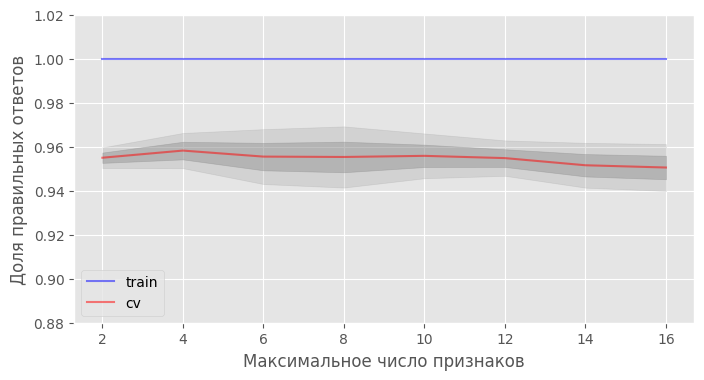

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Доля правильных ответов")
ax.set_xlabel("Максимальное число признаков")

Мы рассмотрели, как ведут себя кривые валидации в зависимости от изменения основных параметров.

Вручную подбирать наилучшие значения параметров нецелесообразно. Значительно легче использовать поиск по сетке с помощью GridSearchCV. Найдем оптимальные параметры для нашего набора данных

In [14]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [6, 8, 10, 12, 14], 'min_samples_leaf': [1, 2, 3],
              'max_depth': [20, 24, 28, 32]}
rfc = RandomForestClassifier(n_estimators=75, random_state=3,
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(os_data_X, os_data_y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=75, n_jobs=-1,
                                              oob_score=True, random_state=3),
             n_jobs=-1,
             param_grid={'max_depth': [20, 24, 28, 32],
                         'max_features': [6, 8, 10, 12, 14],
                         'min_samples_leaf': [1, 2, 3]},
             verbose=1)

Сырые результаты поиска по сетке полным перебором

In [15]:
gcv.cv_results_

{'mean_fit_time': array([1.47525883, 1.89531288, 1.16450734, 1.43239746, 1.64841495,
        2.05977263, 1.66252451, 1.62793088, 2.50734792, 1.89297538,
        2.00748835, 2.47725163, 2.22948904, 3.00346961, 2.00592051,
        1.22965617, 1.67658496, 1.64823141, 1.43181882, 1.42842135,
        2.10853519, 1.88750424, 1.58966203, 2.10704393, 2.30347338,
        1.87504015, 2.58313537, 2.30241232, 2.25625534, 2.70345464,
        1.23010278, 1.2203681 , 1.73999786, 1.91313801, 1.41796541,
        1.41614122, 3.01120014, 2.52705669, 2.97700109, 1.89153552,
        2.14505935, 2.4399734 , 2.13698769, 3.03378911, 2.03835211,
        1.24123039, 1.72381945, 1.54264684, 1.46017356, 1.41318803,
        2.1149188 , 1.87280259, 1.62142859, 2.05271311, 2.25626893,
        1.82474427, 2.58875651, 2.31676111, 2.33995295, 2.57730451]),
 'std_fit_time': array([0.32256678, 0.17194198, 0.04465863, 0.06400686, 0.48332046,
        0.5459464 , 0.03321344, 0.0491997 , 0.49705155, 0.10193517,
        0.393

In [16]:
gcv.best_estimator_

RandomForestClassifier(max_depth=20, max_features=10, n_estimators=75,
                       n_jobs=-1, oob_score=True, random_state=3)

In [17]:
print(gcv.best_params_)

{'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 1}


In [18]:
print(gcv.best_score_)

0.9563662303572894


### Оценка важности признаков

In [19]:
# Инициализируем стратифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

rfc = RandomForestClassifier(n_estimators=75, random_state=3, n_jobs=-1,
                                 oob_score=True, max_features=6, max_depth=24, min_samples_leaf=1)

# Обучаем на обучающей выборке
rfc.fit(os_data_X, os_data_y)

# Оцениваем долю верных ответов на тестовом датасете
print("Доля правильных ответов на кросс-валидации: {:.2f}%".format(results.mean()*100))

Доля правильных ответов на кросс-валидации: 95.89%


Значения важности признаков по средним значениям уменьшениния неопределенности Джини

In [20]:
for name, importance in zip(os_data_X.columns.tolist(), rfc.feature_importances_):
    print(name, "=", importance)

age = 0.03834789527781926
dependents = 0.018528884584197075
year_income = 0.034618481361359435
month_client = 0.027678892443784863
total_products = 0.08114167803931738
m_inactive_12 = 0.023897900876641207
contacts_12 = 0.02355047703297408
credit_limit = 0.05877342926783335
total_amt_chng_Q4Q1 = 0.06748885279596231
total_transactions = 0.22239478859479475
total_ct_chng_Q4Q1 = 0.14965764052773603
avg_utilization_ratio = 0.06035798718274395
gender_F = 0.026850011955416628
gender_M = 0.040322471459426176
edu_level_basic = 0.002027773663646258
edu_level_degree = 0.0
edu_level_general = 0.019935391572956807
edu_level_high = 0.02006926990537418
edu_level_high, not graduated = 0.003726313344948137
marital_status_civil partnership = 0.022272843325843696
marital_status_divorced = 0.008773188309064412
marital_status_married = 0.02051837471162939
marital_status_single = 0.015595702457138256
marital_status_widow = 0.006332715734096789
card_category_Blue = 0.0039148460402665475
card_category_Gold = 

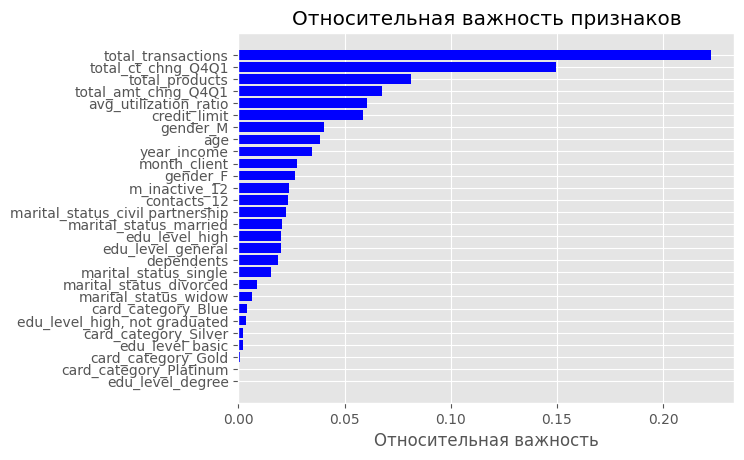

In [21]:
features = os_data_X.columns.tolist()
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.title('Относительная важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Относительная важность')
plt.show()

Наиболее "информативные признаки" для выявления лояльности - это число транзакций, коэффициент изменения числа обращений в банк (Q4 по отношению к Q1), число банковских продуктов, "коэффициент использования кредита" и некоторые другие.

### На тестовой выборке, заранее отложенной

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# проверяем на тестовых данных
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')



Доля правильных ответов Accuracy= 0.9213333333333333
Мера F1= 0.9206013337280943
Точность Precision= 0.9200069010683246
Полнота Recall= 0.9213333333333333


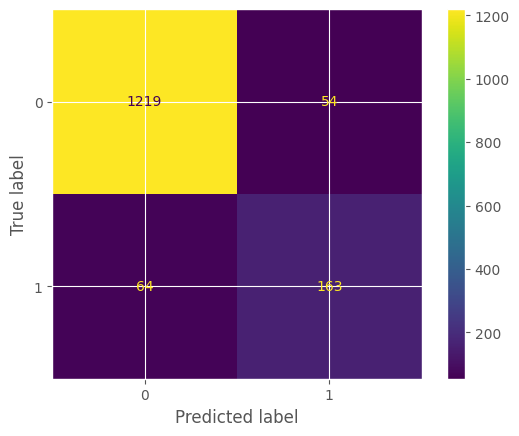

In [23]:
pred = rfc.predict(X_test)

# считаем метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred))
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)

ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test)